In [1]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, LabeledSentence

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

## Words Specific to Positive or Negative Reviews 

First, we'll take a look at what words are representative of the postive reviews and negative reviews. For this purpose, we'd like to keep only the words that carry the most sentiment meaning (i.e. verbs, nouns and adjectives)

In [2]:
train = pd.read_csv("labeledTrainData.tsv",
                    delimiter="\t",
                    header=0,
                    quoting=3)

# Contains each review as [("token", "pos"), ... ], where pos = "N", "J" or "V"
train_sents_sentiment = pickle.load(open("train_sents_sentiment.pickle"))

# Select tokens based on part of speech
def pos_filter(doc, pos=set("NJV")):
    words, pos_tags = zip(*doc)
    selected = [words[i].lower() for i in range(len(words)) if pos_tags[i] in pos]
    return " ".join(selected)

# Noun, adjective or verb
train_njv = map(pos_filter, train_sents_sentiment)
# Only noun
train_n = map(lambda doc: pos_filter(doc, set("N")), train_sents_sentiment)

# Sentiment label
y = train["sentiment"].values

In [3]:
train_njv[0]

u"stuff go moment mj start listen music watch odd documentary watch wiz watch moonwalker want get certain insight guy think cool eighty make mind guilty innocent moonwalker part biography part feature film remember go see cinema release subtle message mj feeling press obvious message drug bad m'kay impressive course michael jackson remotely mj go hate find bore call mj egotist consent making movie but mj fan say make fan true nice actual feature film bit start num minute exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad mj overhear plan nah joe pesci character rant want people know supply drug dunno hat mj music lots cool thing like mj turn car robot whole speed demon sequence director patience saint come film kiddy bad sequence director hate work kid let whole bunch perform complex dance scene bottom line movie people like mj level think people stay try give wholesome message mj best buddy movie girl michael jackson talented people gr

In [4]:
train_n[0]

u"stuff moment mj music documentary wiz moonwalker insight guy eighty mind moonwalker part biography part feature film cinema message mj feeling press message drug m'kay course michael jackson mj mj egotist making movie but mj fan fan feature film bit num minute smooth criminal sequence joe pesci drug lord mj mj plan nah joe pesci character people drug dunno mj music lots thing mj car robot speed demon sequence director patience saint kiddy bad sequence director kid bunch dance scene bottom line movie people mj level people message mj buddy movie girl michael jackson people planet attention subject .hmmm people door fact guy liar latter"

First, we'll simply create the counter object for the words that appear in either category, and show the top 10 most frequent words

In [5]:
pos_counter = Counter()
neg_counter = Counter()

for doc, label in zip(train_njv, y):
    words = doc.split()
    if label == 1:
        pos_counter.update(words)
    else:
        neg_counter.update(words)

In [6]:
pos_counter.most_common(10)

[(u'film', 24685),
 (u'movie', 22216),
 (u'num', 12266),
 (u'see', 10635),
 (u'make', 10090),
 (u'good', 9028),
 (u'get', 8156),
 (u'time', 7946),
 (u'story', 7322),
 (u'great', 6996)]

In [7]:
neg_counter.most_common(10)

[(u'movie', 28377),
 (u'film', 22257),
 (u'num', 13600),
 (u'make', 11992),
 (u'bad', 10508),
 (u'see', 9747),
 (u'get', 9710),
 (u'good', 9378),
 (u'time', 7357),
 (u'go', 7257)]

As we can see, these words are not very informative in distinguishing between the two categories. But there is one interesting observation: the word **good** appeared in the most common words in both postive and negative reviews. I've actually had a chance to skim over a couple of labeled reviews, and I noticed that some reviews started with a lengthy summarization of the plot of the movie, while ended with only a few short sentences expressing opinons about the movie itself. Maybe the word **good** was used very often in describing the movie, rather than indicating the movie is "good". 

To identify the most differentiating words, I tried the approach described in the reddit project https://github.com/chao-ji/reddit/blob/master/Part%205%20Topics%20Over%20Time%20-%20Overrepresented%20Words.ipynb, that computes the log-odds ratio (z-score) of the words that appear in both postive and negative reviews.

In [8]:
global_counter = Counter()
global_counter.update(pos_counter)
global_counter.update(neg_counter)

In [9]:
def zscore(word, counter_i, n_i, 
           counter_j, n_j,
           counter_0, n_0, log=np.log):
    """
    Input: the counter of words in corpus_i and corpus_j, and their sizes(n_i and n_j)
           the counter of words in background corpus_0, and size (n_0)
           
    Function for computing the log-odds ratio. The LARGER the zscore, the MORE overrepresented
    the word `word` is in corpus_i as opposed in corpus_j
    """
    y_i = np.float(counter_i[word])
    y_j = np.float(counter_j[word])
    a_w = np.float(counter_0[word])

    ratio_i = (y_i + a_w) / (n_i + n_0 - y_i - a_w)
    ratio_j = (y_j + a_w) / (n_j + n_0 - y_j - a_w)

    if ratio_i < 0.:
        raise ValueError("ratio_i is negative: %f\n" % ratio_i)
    if ratio_j < 0.:
        raise ValueError("ratio_j is negative: %f\n" % ratio_j)

    logratio = log(ratio_i) - log(ratio_j)

    try:
        var_logratio = 1. / (y_i + a_w) + 1. / (y_j + a_w)
    except ZeroDivisionError as inst:
        print inst

    try:
        z = logratio / np.sqrt(var_logratio)
    except Exception as inst:
        print inst

    return z

We need to find the common words that appear in both positive and negative reviews, and compute their zscores, and visualize the distribution of zscores

In [10]:
common = set(pos_counter.keys()) & set(neg_counter.keys())
common = list(common)

n_i = sum(pos_counter.values())
n_j = sum(neg_counter.values())
n_0 = sum(global_counter.values())

df = [(w, zscore(w, counter_i=pos_counter, n_i=n_i,
                 counter_j=neg_counter, n_j=n_j,
                 counter_0=global_counter, n_0=n_0)) for w in common]

In [11]:
df = pd.DataFrame(np.array(zip(*df)).T, columns=["word", "zscore"])
df["zscore"] = df["zscore"].astype(np.float)
df = df.sort_values(by="zscore")

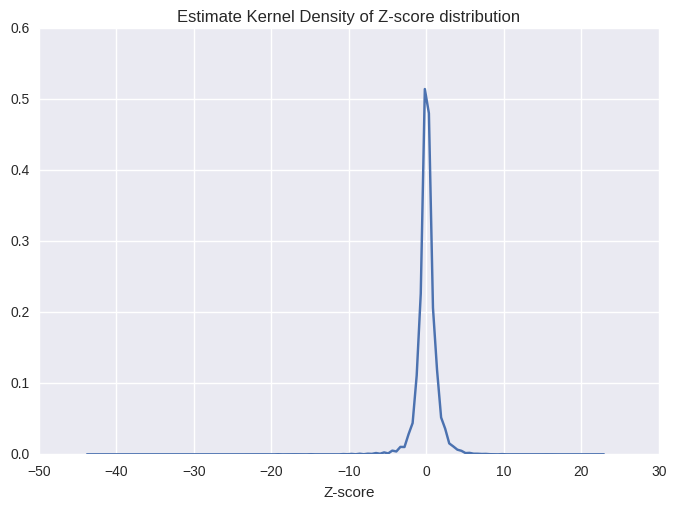

In [12]:
sns.kdeplot(df["zscore"].values)
plt.xlabel("Z-score")
plt.title("Estimate Kernel Density of Z-score distribution")
plt.show()

It appears that the majority of words are used a lot in both positive and negative reviews. But we can visualize those words with **high specificity** using wordcloud:

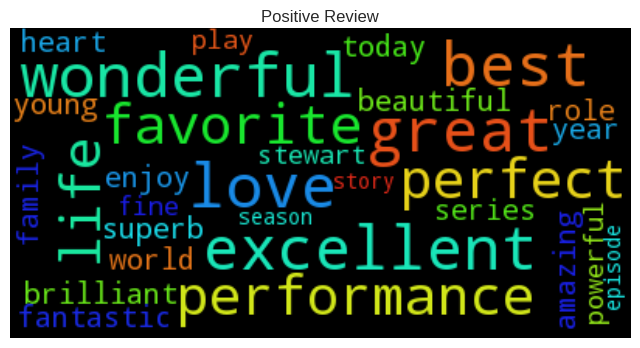

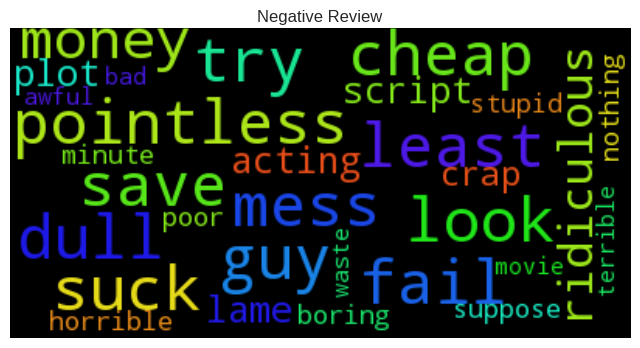

In [13]:
from wordcloud import WordCloud

pos = dict(df.iloc[-30:, :].values)
neg = dict(df.iloc[:30, :].values)

wc_pos = WordCloud(max_font_size=40).generate_from_frequencies((k, pos[k]) for k in pos.keys())
wc_neg = WordCloud(max_font_size=40).generate_from_frequencies((k, neg[k]) for k in neg.keys())

plt.imshow(wc_pos)
plt.title("Positive Review")
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(wc_neg)
plt.title("Negative Review")
plt.xticks([])
plt.yticks([])
plt.show()

The wordcloud makes a lot of sense, however, these words specific to either class are likely presently mostly in the two tails of the z-score distributions, while the majority of words are shared in both positive and negative reviews. 

## Clustering (LSA and KMeans)

In this part, we'll try to find if there is way to segment reviews into cohesive clusters. The corpus with bag-of-words representation will be turned into vectors with topic weights representation, and a kmeans clustering algorithm will be applied on the topic representation. 

Different hyperparameters will be considered: the number of components(topics), and the number of clusters

Topic representation will be obtained using **LSA** (implemented using scikitlearn's `TruncatedSVD`). The silhouette score (or plot the elbow curve) will be used for assessing the cohesiveness of the clusters.

In [14]:
# We sample a subset of reviews to speed up the clustering process
def sample_corpus(corpus, y, sample_size=2000):
    index = np.random.choice(len(corpus), sample_size, replace=False)
    sample = [corpus[i] for i in index]
    sample_target = [y[i] for i in index]
    return sample, sample_target

The corpus will be tfidf-vectorized and then normalized (l2 norm equal 1.0)

In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

train_njv_sample, sample_target = sample_corpus(train_njv, y)

vectorizer = TfidfVectorizer(max_df=0.5, max_features=5000,
                             min_df=2, stop_words='english',
                             use_idf=True)
X = vectorizer.fit_transform(train_njv_sample)

lsa = Pipeline([("svd", TruncatedSVD()), ("normalizer", Normalizer())])
km = KMeans()

In [16]:
X.shape

(2000, 5000)

In [17]:
sample_target = np.array(sample_target)
sample_target.shape

(2000,)

We'll do a grid search of the combinations of
* The number of dimensions in LSA
* The number of clusters

In [18]:
n_dims = [2, 5, 15, 20, 25, 30] # num of topics in LSA
K = range(2, 51) # num of clusters for kmeans

silhouette_scores = []
for n_components in n_dims: # The number of dimensions in LSA
#    print n_components
    X_svd = lsa.set_params(svd__n_components=n_components).fit_transform(X)
    scores = []
    for k in K: # The number of clusters
        km.set_params(n_clusters=k).fit(X_svd)
        labels = km.labels_
        scores.append(silhouette_score(X_svd, labels))
    silhouette_scores.append(scores)
silhouette_scores = np.array(silhouette_scores)

Note that the silhouette scores decrease as the number of dimensions increases

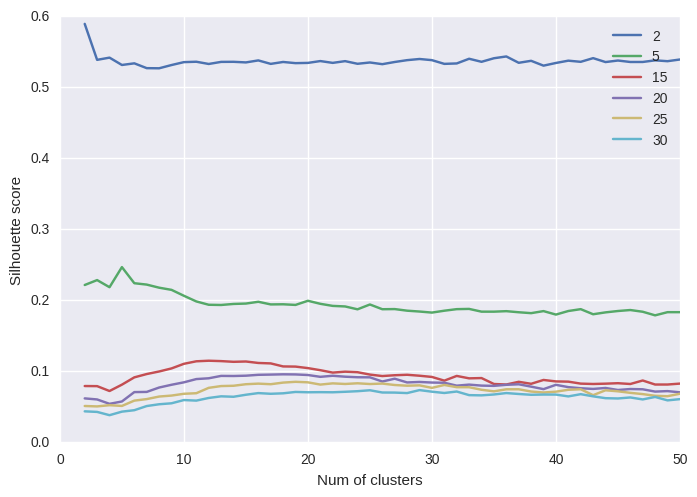

In [19]:
for i in range(len(silhouette_scores)):
    plt.plot(K, silhouette_scores[i])

plt.ylabel("Silhouette score")    
plt.xlabel("Num of clusters")    
plt.legend(map(str, n_dims))
plt.show()

So we'll compensate for this by multiplying silhouette scores by the number of dimensions:

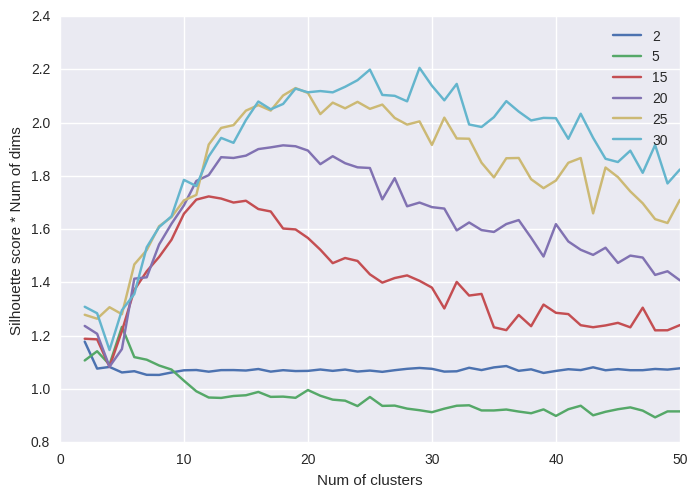

In [20]:
for i in range(len(silhouette_scores)):
    plt.plot(K, silhouette_scores[i] * n_dims[i])

plt.ylabel("Silhouette score * Num of dims")    
plt.xlabel("Num of clusters")    
plt.legend(map(str, n_dims))
plt.show()

As we can see, when the number of dimensions was low (2 and 5), there appears to be a single maximizer of the silhouette score over the different numbers of clusters. However, when the data is projected to a higher dimensional space, the score first increases with the number of clusters and then plateaus.

Next we'll try to visualize the reviews in topic representation in 2-dimensional space

In [21]:
X_svd30 = lsa.set_params(svd__n_components=30).fit_transform(X)
X_svd30.shape

(2000, 30)

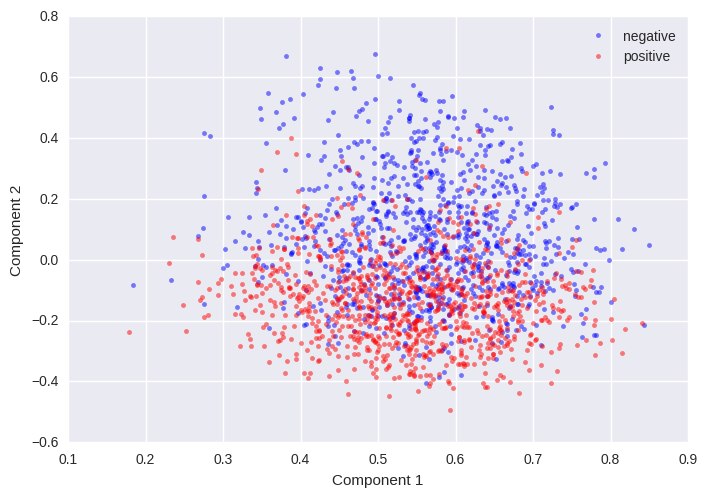

In [22]:
# b = negative, r = positive
plt.plot(X_svd30[sample_target==0, 0], X_svd30[sample_target==0, 1], "b.", alpha=0.5)
plt.plot(X_svd30[sample_target==1, 0], X_svd30[sample_target==1, 1], "r.", alpha=0.5)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(["negative", "positive"])
plt.show()

As we can see, when projected into 2-D space, though not very well separated, positve and negative reviews seem to form clusters

## Topic Modeling

In this part, we'll apply more sophisticated topic modeling algorithms. As opposed to Latent Dirichlet Allocation (LDA), we'll try Hierachical Dirichlet Process (HDP) as it is able to determine the optimal number of clusters.

We'll apply HDP separately on positive and negative reviews.

Finally we'll use a fantanstic tool pyLDAvis (https://pyldavis.readthedocs.io/en/latest/) that is able to generate interactive plots for topic models

In [23]:
from gensim import corpora, models

# function that turns corpus that contains "token token token" into ["token", "token", "token"], 
# and filters out tokens whose frequency is below cutoff
def process_corpus(corpus, word_freq_cutoff=1):
    corpus = [doc.split() for doc in corpus]
    
    if isinstance(word_freq_cutoff, int) and word_freq_cutoff >= 0:
        freq = Counter()
        for doc in corpus:
            freq.update(doc)
    
        corpus = [filter(lambda token: freq[token] > word_freq_cutoff, doc) for doc in corpus]
    return corpus   

Define a helper function `train_topic_model` that
* Split the reviews into positive and negative class
* Sample a subset of reviews in each class
* Construct the dictionary, corpus, tfidf model in **gensim** format
* Build the HDP model separately for positive and negative class

In [24]:
# We'll sample 7500 reviews from 12500 reviews separately for postive and negative reviews (25000 total)
def train_topic_model(corpus, y, sample_size=7500):
    pos_corpus = [corpus[i] for i in range(len(corpus)) if y[i] == 1]
    neg_corpus = [corpus[i] for i in range(len(corpus)) if y[i] == 0]
    
    pos_corpus_sample, _ = sample_corpus(pos_corpus, y, sample_size=sample_size)
    neg_corpus_sample, _ = sample_corpus(neg_corpus, y, sample_size=sample_size)

    pos_texts = process_corpus(pos_corpus_sample, word_freq_cutoff=2)
    neg_texts = process_corpus(neg_corpus_sample, word_freq_cutoff=2)    
    
    pos_dictionary = corpora.Dictionary(pos_texts)
    pos_corpus = [pos_dictionary.doc2bow(text) for text in pos_texts]
    pos_tfidf = models.TfidfModel(pos_corpus)
    pos_corpus_tfidf = pos_tfidf[pos_corpus]

    neg_dictionary = corpora.Dictionary(neg_texts)
    neg_corpus = [neg_dictionary.doc2bow(text) for text in neg_texts]
    neg_tfidf = models.TfidfModel(neg_corpus)
    neg_corpus_tfidf = neg_tfidf[neg_corpus]

    pos_hdp = models.hdpmodel.HdpModel(pos_corpus_tfidf, id2word=pos_dictionary)
    neg_hdp = models.hdpmodel.HdpModel(neg_corpus_tfidf, id2word=neg_dictionary)
    
    return [(pos_hdp, pos_corpus_tfidf, pos_dictionary), (neg_hdp, neg_corpus_tfidf, neg_dictionary)]

Train the model:

In [25]:
pos_model, neg_model = train_topic_model(train_njv, y)

In pyLDAvis, the distance between topics (represented by probability distribution of words) is computed as Jensen-Shannon Divergence, and then Multidimensional scaling is used to embed the topics represented by pairwise JS Divergence into 2-D space for visualization.

Topic visualization of positive reviews:

## Note:  the following images are just screenshots if accessed from github. For interactive plots, go to
http://nbviewer.jupyter.org/github/chao-ji/movie_review/blob/master/Part%205%20Misc%20%28Wordcloud%2C%20Clustering%2C%20Topic%20Modeling%29.ipynb 

In [26]:
import pyLDAvis
from pyLDAvis import gensim

data = gensim.prepare(pos_model[0], pos_model[1], pos_model[2])
pyLDAvis.display(data)

<img src="pos_njv.png">

Topic visualization of negative reviews:

In [27]:
data = gensim.prepare(neg_model[0], neg_model[1], neg_model[2])
pyLDAvis.display(data)

<img src="neg_njv.png">

Next, we'll identify what are the words that are used in most of the reviews, namely, the words with low IDF (or high DF)

In [28]:
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
vectorizer.fit(train_njv)

# Number of inverse-doc frequency, Number of tokens
print vectorizer.idf_.shape, len(vectorizer.get_feature_names())

(66345,) 66345


Top 30 words with lowest inverse document frequency

In [29]:
df = pd.DataFrame([vectorizer.idf_, vectorizer.get_feature_names()], index=["idf", "word"]).T
df.sort_values("idf", ascending=True)[:30]

,idf,word
39015,1.43446,movie
20899,1.5226,film
40954,1.65566,num
35514,1.67905,make
24126,1.79837,good
59183,1.898,time
63940,2.03421,watch
9637,2.11308,character
56128,2.14285,story
58834,2.15891,think


## Insight for Visualized Topic Models

As we can see, these words with high document frequency align pretty well with those that appear in the big circles from pyLDAvis (Topic #1, the most prevalent). 

Based on these results, we can say that most of the movie reviews in IMDB (positive or negative) has two major components:
1. Describe the movie in general terms, in which the user used words that is not specific to the movie (e.g. plot, scence, director, character, movie, file etc.)
2. Use words that are highly unique to the movie (e.g. character names, actor/actress names, dicretor names, words used to express opinions about the movie)

This would make sense, because these documents were all sampled from IMDB, where people review movies they have watched, so they have to use words that everyone else uses anyways. On the other hand, the set of movies reviewed may be highly diverse across the corpus, so in each review the user must have used words that are highly specific.

That's why we end up seeing the ***gigantic circle*** (words related to movies in general) together with a large number of ***tiny circles*** (words highly specific to different movies) across the space.

Previously, we considered tokens with **all possible part of speech tags** (N, J, V). Now let's repeat the HDP training and visualization using **only Nouns**:

In [30]:
pos_noun_model, neg_noun_model = train_topic_model(train_n, y)

In [31]:
data = gensim.prepare(pos_noun_model[0], pos_noun_model[1], pos_noun_model[2])
pyLDAvis.display(data)

<img src="pos_n.png">

In [32]:
data = gensim.prepare(neg_noun_model[0], neg_noun_model[1], neg_noun_model[2])
pyLDAvis.display(data)

<img src="neg_n.png">

This time the distribution of topic sizes is much more uniform (no big circles anymore). Take a close look at the top most relevant terms in each circle, we can see that they appeared to be very unique and specific to different movies.

### HDP to LDA

Note that in gensim implementation, we can obtain the LDA equivalent of HDP using **hdp_to_lda()**

In [33]:
A, B = pos_model[0].hdp_to_lda()

A is an 1-D array of shape (n_topics, ) that contains the probability of topics ($\alpha$ in the Dirichlet distribution in the original formulation of LDA), while B is a 2-D array of shape (num_topics, num_words) where each row contains the probability of words for each of the topics ($\beta$ in the original formulation of LDA) 

In [34]:
A.shape

(150,)

In [35]:
B.shape

(150, 18311)

In [36]:
A

array([ 0.02585577,  0.02182071,  0.01968248,  0.01977971,  0.01466792,
        0.01526298,  0.01411813,  0.01363894,  0.01260909,  0.01156131,
        0.01137366,  0.01033961,  0.00943789,  0.0093673 ,  0.00834144,
        0.00597961,  0.00994135,  0.00893376,  0.01036433,  0.0108145 ,
        0.00870052,  0.0088947 ,  0.00985322,  0.00940629,  0.0110493 ,
        0.00720811,  0.00749718,  0.0060793 ,  0.00797273,  0.00590384,
        0.00791708,  0.00797199,  0.00754522,  0.00524218,  0.00678433,
        0.00597483,  0.00837731,  0.00635651,  0.00833298,  0.00712406,
        0.00724145,  0.00768082,  0.00588808,  0.00649087,  0.00677435,
        0.00715525,  0.00706032,  0.00926571,  0.00733228,  0.00454583,
        0.00622994,  0.00637631,  0.00769785,  0.00619042,  0.0067895 ,
        0.00739698,  0.00686003,  0.00638451,  0.00745087,  0.0048597 ,
        0.00708411,  0.00637152,  0.00816155,  0.0052564 ,  0.00652919,
        0.00643805,  0.00779455,  0.00610634,  0.0060471 ,  0.00

In [37]:
B

array([[  1.06706346e-04,   8.75009665e-05,   9.71020044e-06, ...,
          1.14459627e-04,   2.54140164e-05,   1.00042051e-06],
       [  1.49750582e-05,   6.86392090e-05,   7.65674917e-05, ...,
          4.11771350e-05,   4.24642438e-05,   8.77633355e-05],
       [  2.31371912e-05,   1.76672942e-05,   2.64400498e-05, ...,
          8.99383779e-05,   6.75142639e-05,   3.82995127e-05],
       ..., 
       [  1.98306526e-05,   8.85813344e-06,   8.42337100e-05, ...,
          1.06175938e-04,   5.09078513e-05,   7.31213432e-05],
       [  1.35227658e-05,   1.30376356e-05,   2.14513268e-05, ...,
          5.70019644e-05,   2.13985024e-05,   7.79209326e-05],
       [  8.64204149e-05,   6.44708579e-06,   6.02630515e-06, ...,
          2.07894280e-05,   2.39753838e-05,   1.09343848e-06]])

Elements in A and rows of B sum up to 1.0:

In [38]:
A.sum()

1.0

In [39]:
B.sum(axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])